In [1]:
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from itertools import product

# --- 1) Load data ---
X = np.load("Data/X_train.npy")  # (700,6)
y = np.load("Data/Y_train.npy")  # (700,)

# --- 2) Outlier detection ---
X_scaled = StandardScaler().fit_transform(X)

# Z-score
zs = np.abs(zscore(X_scaled))
z_thresh = 3.0
outlier_mask_z = (zs > z_thresh).any(axis=1)

# IsolationForest
iso = IsolationForest(contamination=0.01, random_state=42)
is_outlier_iso = iso.fit_predict(X_scaled) == -1

# Combine
outlier_union = outlier_mask_z | is_outlier_iso
final_mask = ~outlier_union   # keep only non-outliers

X_clean = X[final_mask]
y_clean = y[final_mask]

print("Outliers removed:", outlier_union.sum())
print("Clean data shape:", X_clean.shape, y_clean.shape)

# --- 3) Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)

# --- 4) Scale features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- 5) RBF transform function ---
def rbf_transform(X, centers, sigma):
    diff = X[:, np.newaxis, :] - centers[np.newaxis, :, :]
    return np.exp(-np.sum(diff**2, axis=2) / (2*sigma**2))

# --- 6) Hyperparameter grids ---
sigma_list = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
n_centers_list = [150, 175, 200, 225, 250]
alpha_list = [0.0005, 0.00075, 0.001, 0.005, 0.01]

# --- 7) K-Fold CV for hyperparameter search ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)
best_r2 = -np.inf
best_params = None
results = []

for sigma, n_centers, alpha in product(sigma_list, n_centers_list, alpha_list):
    r2_scores = []
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # KMeans centers on fold
        kmeans = KMeans(n_clusters=n_centers, random_state=42)
        kmeans.fit(X_tr)
        centers = kmeans.cluster_centers_

        # RBF transformation
        X_tr_rbf = rbf_transform(X_tr, centers, sigma)
        X_val_rbf = rbf_transform(X_val, centers, sigma)

        # Ridge regression
        model = Ridge(alpha=alpha)
        model.fit(X_tr_rbf, y_tr)

        # Validation
        y_val_pred = model.predict(X_val_rbf)
        r2_scores.append(r2_score(y_val, y_val_pred))

    mean_r2 = np.mean(r2_scores)
    results.append({'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha, 'mean_r2': mean_r2})

    if mean_r2 > best_r2:
        best_r2 = mean_r2
        best_params = {'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha}

print("Best CV R2:", best_r2)
print("Best hyperparameters:", best_params)

# --- 8) Train final model on all clean training data ---
kmeans_final = KMeans(n_clusters=best_params['n_centers'], random_state=42).fit(X_train_scaled)
X_train_rbf_final = rbf_transform(X_train_scaled, kmeans_final.cluster_centers_, best_params['sigma'])
X_test_rbf_final  = rbf_transform(X_test_scaled,  kmeans_final.cluster_centers_, best_params['sigma'])

final_model = Ridge(alpha=best_params['alpha']).fit(X_train_rbf_final, y_train)
y_test_pred = final_model.predict(X_test_rbf_final)
print("Final Test R2:", r2_score(y_test, y_test_pred))


Outliers removed: 10
Clean data shape: (690, 6) (690,)
Best CV R2: 0.9809463046588647
Best hyperparameters: {'sigma': 2.0, 'n_centers': 250, 'alpha': 0.0005}
Final Test R2: 0.9826084177371254


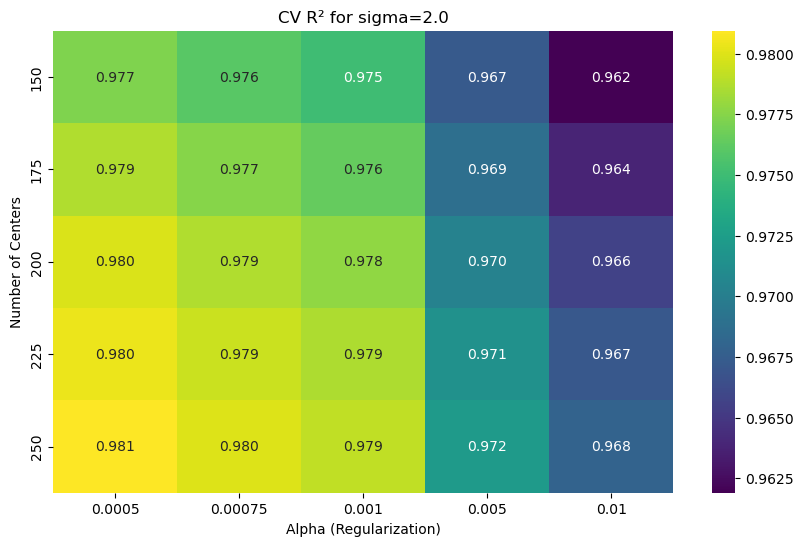

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Converter lista de resultados em DataFrame
df_results = pd.DataFrame(results)

# Agora podemos fazer o subset para o melhor sigma
best_sigma = best_params['sigma']
subset = df_results[df_results['sigma'] == best_sigma]

# Criar pivot table para heatmap
pivot = subset.pivot(index='n_centers', columns='alpha', values='mean_r2')

plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".3f", cmap='viridis')
plt.title(f"CV R² for sigma={best_sigma}")
plt.xlabel("Alpha (Regularization)")
plt.ylabel("Number of Centers")
plt.show()


In [ ]:
for sigma, n_centers, alpha in product(sigma_list, n_centers_list, alpha_list):
    r2_scores = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_scaled), start=1):
        X_tr, X_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        kmeans = KMeans(n_clusters=n_centers, random_state=42)
        kmeans.fit(X_tr)
        centers = kmeans.cluster_centers_

        X_tr_rbf = rbf_transform(X_tr, centers, sigma)
        X_val_rbf = rbf_transform(X_val, centers, sigma)

        model = Ridge(alpha=alpha)
        model.fit(X_tr_rbf, y_tr)
        y_val_pred = model.predict(X_val_rbf)
        r2_scores.append(r2_score(y_val, y_val_pred))

    mean_r2 = np.mean(r2_scores)
    results.append({'sigma': sigma, 'n_centers': n_centers, 'alpha': alpha, 'mean_r2': mean_r2})

    # Log detalhado
    print(f"Sigma={sigma}, Centers={n_centers}, Alpha={alpha}, Mean R²={mean_r2:.4f}")
